In [144]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from math import *
from astroML.time_series import generate_damped_RW
import argparse
import random
#%matplotlib qt
%matplotlib inline

In [145]:
data = np.loadtxt('RXJ1131_ALL.rdb',skiprows=2)
data1=np.genfromtxt('HE0435_ECAM.rdb',skip_header=2)
time = np.sort(np.concatenate((data[:,0],data1[:,0])))

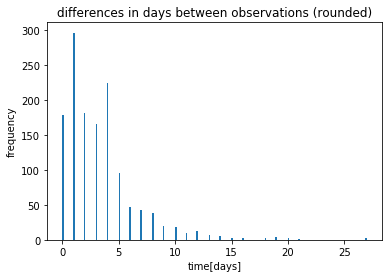

In [155]:
def hist_day(array,bins_):
    diff = np.array([])
    for i in range(1,len(array)):
        diff = np.append(diff,array[i]-array[i-1])
    rounded=np.round(diff)
    rounded = rounded[rounded<30]
    plt.hist(rounded,bins=bins_)
    plt.title('differences in days between observations (rounded)')
    plt.xlabel('time[days]')
    plt.ylabel('frequency')
    return diff,rounded,plt.show()
rounded = hist_day(time,200)[1]

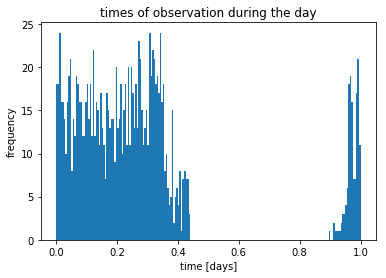

In [147]:
def hist_time(array,bins_):
    day_time = np.array([])
    for i in range(1,len(array)):
        day_time = np.append(day_time,array[i]-np.floor(array[i]))
    plt.hist(day_time,bins=bins_)
    plt.xlabel('time [days]')
    plt.ylabel('frequency')
    plt.title('times of observation during the day')
    return day_time, plt.show()
day_time = hist_time(time,200)[0]

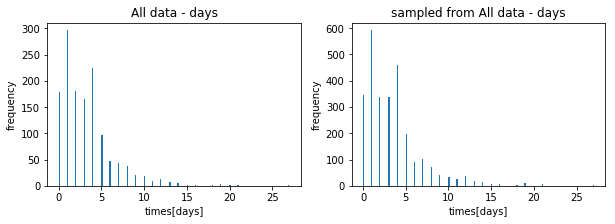

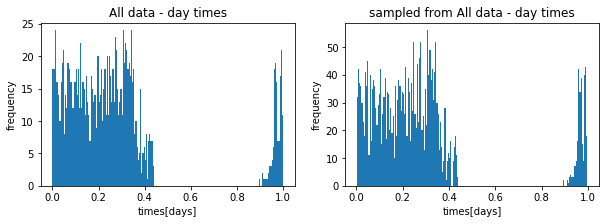

In [158]:
def sample_data(array,data_name,num,flag=False):  # array = time arrays
    '''array is the data to sample from
        data_name is the name of the data set
        num is the number of random values we want sampled
        flag: should be set to True if the random samples numbers need to be rounded'''
    bins_= 200
    data = array
    hist, bins = np.histogram(array, bins=bins_)

    bin_midpoints = bins[:-1] + np.diff(bins)/2
    cdf = np.cumsum(hist)
    cdf = cdf / cdf[-1]
    values = np.random.rand(num)
    value_bins = np.searchsorted(cdf, values)
    random_from_cdf = bin_midpoints[value_bins]
    f = plt.figure(figsize=(10,3))
    f.add_subplot(121)
    plt.hist(data, bins_)
    plt.ylabel('frequency')
    plt.xlabel('times[days]')
    plt.title(data_name)
    f.add_subplot(122)
    if flag==True:
        random_from_cdf = np.round(random_from_cdf)
    plt.hist(random_from_cdf, bins_)
    plt.title('sampled from '+data_name)
    plt.ylabel('frequency')
    plt.xlabel('times[days]')
    return plt.show(),random_from_cdf
rand_days_ = sample_data(rounded,'All data - days',len(time)*2,True)[1]
rand_times_ = sample_data(day_time,'All data - day times',len(time)*2)[1]
rand_obs_diff = rand_days_+rand_times_

In [150]:
t_drive_new = np.array([np.min(time)])
i=0
while (np.max(t_drive_new)<np.max(time)) and (len(t_drive_new)<len(time)):
    t_drive_new = np.append(t_drive_new,t_drive_new[-1]+rand_obs_diff[i])
    i+=1

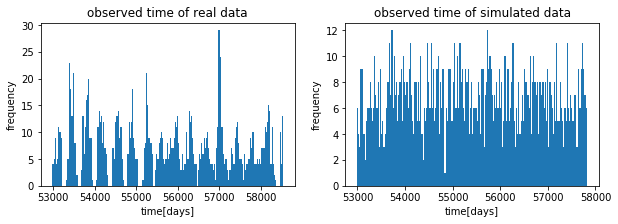

In [151]:
g = plt.figure(figsize=(10,3))
g.add_subplot(121)
plt.hist(time,200)
plt.title('observed time of real data')
plt.xlabel('time[days]')
plt.ylabel('frequency')
g.add_subplot(122)
plt.hist(t_drive_new,200)
plt.title('observed time of simulated data')
plt.xlabel('time[days]')
plt.ylabel('frequency')
plt.show()

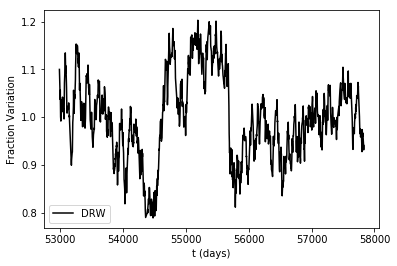

In [160]:
'''simulating data using the sampling about as the time axis'''

parser = argparse.ArgumentParser(formatter_class=argparse.ArgumentDefaultsHelpFormatter)
parser.add_argument('--time_initial'  , '-ti  ', type=float, default=-365.        ,help='Set the initial time (default: t=-365 [day])')
parser.add_argument('--time_final'    , '-tf  ', type=float, default=365.         ,help='Set the final time (default: t=365 [day])')
parser.add_argument('--delta_time'    , '-dt  ', type=float, default=0.1          ,help='Set the time interval (default: dt=0.1 [day])')
parser.add_argument('--fname'         , '-fn  ', type=str  , default='LC_DRW.txt' ,help='Set the output filename (default: LC_DRW.txt)')

parser.add_argument('--tau'           , '-tau ', type=float, default=300          ,help='Set the relaxation time (default: tau=300)')
parser.add_argument('--strc_func_inf' , '-sf  ', type=float, default=0.1          ,help='Set the structure function at infinity (default: SFinf=0.1)')
parser.add_argument('--xmean'         , '-xmu ', type=float, default=1.           ,help='Set the mean value of random walk (default: Xmean=1.)')
parser.add_argument('--ran_seed'      , '-sn  ', type=str  , default='123'        ,help='Set the random seed (r: random, snnn: random seed)')
parser.add_argument('--redshift_src'  , '-zs'  , type=float, default=0.5          ,help='Set the redshift of source (default: zs=0.5)')

parser.add_argument('--target_dir'    , '-td'  ,             default='.',          help='Set the output directory')


args = parser.parse_args()

ti = args.time_initial
tf = args.time_final
dt = args.delta_time
fn = args.fname

xmean = args.xmean
tau = args.tau
SFinf = args.strc_func_inf
zs = args.redshift_src
sn = args.ran_seed

stem_out = args.target_dir


if (sn == 'r'):
    np.random.seed()
else:
    sn = int(sn)
    np.random.seed(sn)

###########################################


########################
#      light curve     #
########################

for i in [1]:

    sn = np.random.randn(1)

#     print('-------------------------------')
#     print('       light curve (DRW)       ')
#     print('-------------------------------')
#     print('Xmean =',xmean)
#     print('tau   =',tau,'day')
#     print('zs    =',zs)
#     print('SFinf =','{0:.3f}'.format(SFinf))
#     print('sn    =',sn)

    #t_drive = np.arange(ti, tf, dt)
#     ti= np.min(time)
#     tf = np.max(time)
#     dt = rand_times_
    t_drive = t_drive_new
    f_drive = generate_damped_RW(t_drive, tau=tau, z=zs, SFinf=SFinf, xmean=xmean)

    f_drive = abs(f_drive)
    mean = np.mean(f_drive)
    std  = np.std( f_drive)

#     print('Light Curve:','from',ti,'to',tf,'days')
#     print('mean =','{0:.3f}'.format(mean),'std =','{0:.3f}'.format(std))

    fn = stem_out+'/'+fn

    #np.savetxt(fn,np.array([t_drive, f_drive]).T,fmt='%f')

    plt.plot(t_drive, f_drive,  color='black', label='DRW')
    plt.xlabel('t (days)')
    plt.ylabel('Fraction Variation')
    plt.legend(loc=3)
    plt.show()